In [1]:
import torch 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pymatgen.core import Structure
from cdft.dft3d import dft_core
from cdft.lj_eos import lj_eos

device = torch.device('cuda')

In [2]:
sigma = 3.73
epsilon = 148.0
parameters = {'sigma':sigma, 'epsilon':epsilon}

In [3]:
structure = Structure.from_file('structures/IRMOF-1.cif')
print('formula:        ', structure.formula)
print('num_sites:      ', structure.num_sites)
print('lattice_lengths:', structure.lattice.lengths)

formula:         Zn32 H96 C192 O104
num_sites:       424
lattice_lengths: (25.832, 25.832, 25.832)


/home/lucas/miniforge3/envs/torch/lib/python3.12/site-packages/pymatgen/core/structure.py:3100: UserWarning: Issues encountered while parsing CIF: Skipping relative stoichiometry check because CIF does not contain formula keys.
  struct = parser.parse_structures(primitive=primitive)[0]


In [4]:
T = 298.0
system_size = np.array([l for l in structure.lattice.lengths])
points = np.array([64, 64, 64])
dft = dft_core(parameters=parameters, temperature=T, system_size=system_size, angles=None, points=points, device=device)
dft.cell_size

array([0.403625, 0.403625, 0.403625])

In [5]:
forcefield = pd.DataFrame()
forcefield['type'] = ['C','H','O','Zn']
forcefield['sigma'] = np.array([3.47299, 2.84642, 3.03315, 2.4615])
forcefield['epsilon'] = np.array([47.8562, 7.64893, 48.1581, 62.3992])

def lj_potential(r,sigma,epsilon):
    return 4.0*epsilon*((sigma/r)**12-(sigma/r)**6) 

rc = 12.9

Vext = torch.zeros_like(dft.X)
U = torch.zeros_like(dft.X)
for k, site in enumerate(structure):
    sigmas = float(forcefield['sigma'][forcefield['type']==site.species_string].values[0])
    epsilons = float(forcefield['epsilon'][forcefield['type']==site.species_string].values[0])
    sigmasf = 0.5*(sigma+sigmas) 
    epsilonsf = np.sqrt(epsilon*epsilons)
    rx = dft.X-structure.cart_coords[k,0] 
    ry = dft.Y-structure.cart_coords[k,1] 
    rz = dft.Z-structure.cart_coords[k,2] 
    rx -= system_size[0]*(rx/system_size[0]).round()
    ry -= system_size[1]*(ry/system_size[1]).round()
    rz -= system_size[2]*(rz/system_size[2]).round()
    r = torch.sqrt(rx**2+ry**2+rz**2)
    U = lj_potential(r,sigmasf,epsilonsf)
    U[r==0] = np.inf
    U[r>rc] = 0.0
    Vext += U

Text(0, 0.5, '$y$ (\\AA{})')

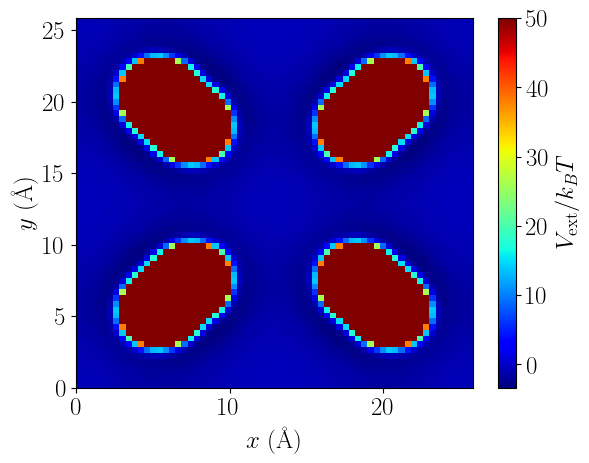

In [6]:
plt.rcParams.update({'text.usetex':True, 
'font.family':'serif', 
'font.size':18, 
# 'axes.linewidth':1.1, 
'lines.linewidth':1.6,
'legend.fontsize': 18,
'legend.frameon':False
#'figure.figsize':(7.9, 6.1)
})


plt.figure()
c=plt.pcolormesh(dft.X[:,:,points[0]//2].cpu(),dft.Y[:,:,points[1]//2].cpu(),Vext[:,:,points[2]//2].cpu()/T,vmax=50.0,cmap='jet')
plt.colorbar(label=r'$V_{\mathrm{ext}}/k_B T$')
plt.xlabel(r'$x$ (\AA{})')
plt.ylabel(r'$y$ (\AA{})')

In [7]:
P = torch.hstack((torch.arange(1e4,1e5,1e4,dtype=torch.float64), torch.arange(1e5,1e6,1e5,dtype=torch.float64), 
                  torch.range(1e6,1e7,1e6,dtype=torch.float64)))
bulk_density = torch.empty_like(P)

eos = lj_eos(parameters, T)
bulk_density[0] = eos.density(P[0],'vap')
for i in range(1,len(P)):
    bulk_density[i] = eos.density(P[i],bulk_density[i-1])

/tmp/ipykernel_30080/3748726064.py:2: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  torch.range(1e6,1e7,1e6,dtype=torch.float64)))


In [8]:
dft.initial_condition(bulk_density[0],Vext)

In [9]:
Nads = torch.empty(len(P),dtype=torch.float64)
for i in range(len(P)):
    dft.equilibrium_density_profile(bulk_density[i],fmt='ASWB',solver='anderson',
                                    anderson_mmax=10,anderson_damping=0.2,tol=1e-6,logoutput=False)
    Nads[i] = dft.total_molecules
    print(dft.it,dft.error.numpy(),1e-5*P[i].numpy(),Nads[i].numpy())
    if np.isnan(dft.error.numpy()): break

5 1.3747793670197386e-07 0.1 0.24686630508357574
6 1.7241531598800615e-07 0.2 0.4939099845395763
6 1.0410133470100864e-07 0.30000000000000004 0.7411249044881318
5 6.416544851673624e-07 0.4 0.9885050388238509
5 3.247240912385636e-07 0.5 1.2360439680471793
5 1.9249284676381559e-07 0.6000000000000001 1.4837359773133068
5 1.1818106914566671e-07 0.7000000000000001 1.7315750686188887
5 6.953475742016852e-08 0.8 1.9795553027664134
5 3.866182617423299e-08 0.9 2.227670783923927
5 3.4608201228959056e-08 1.0 2.4759156558728868
9 3.040255425050525e-08 2.0 4.964219347849689
7 4.434654657295285e-07 3.0000000000000004 7.459289235091652
8 2.9540101486726304e-07 4.0 9.955822203971758
8 5.0427743377428115e-08 5.0 12.448819253617492
8 3.6629526588364946e-08 6.000000000000001 14.933531066578391
8 1.1088441631493968e-07 7.000000000000001 17.405461199526982
8 2.2563969541472182e-07 8.0 19.86035955205866
8 4.0304547459607524e-07 9.0 22.294229862241973
8 6.683032061758276e-07 10.0 24.703342454278406
17 1.8573

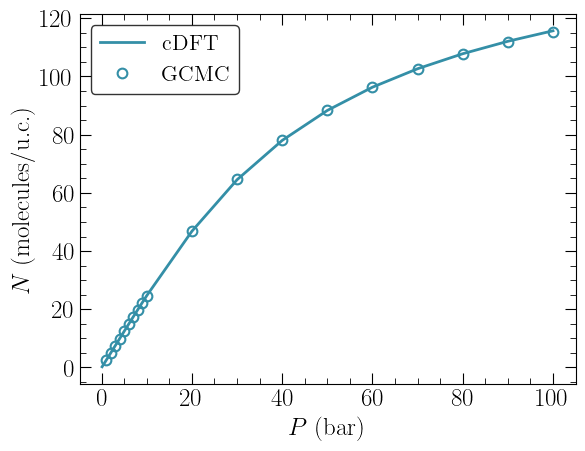

In [10]:
data = pd.read_pickle(f'data/methane_IRMOF-1_{T:.2f}K.pkl')

import seaborn as sns

colors = sns.color_palette("mako")

plt.rcParams.update({'text.usetex':True, 
'font.family':'serif',  
#'figure.figsize':(7.9, 6.1)
})

plt.plot(P*1e-5, Nads, '-', color=colors[3], linewidth=2.0, label='cDFT')
plt.plot(1e-5*data['Pressure (Pa)'], data['Absolute adsorption (molecules/uc)'], 'o', 
         color=colors[3],markersize=7,markeredgewidth=1.5,mfc='none',label='GCMC')
plt.xlabel(r'$P$ (bar)', fontsize=18)
plt.ylabel(r'$N$ (molecules/u.c.)', fontsize=18)
# plt.xlim([0.0,125])
# plt.ylim([None,0.004])
plt.minorticks_on()
plt.tick_params(direction='in',right=True, top=True)
plt.tick_params(labelsize=18)
plt.tick_params(labelbottom=True, labeltop=False, labelright=False, labelleft=True)
plt.tick_params(direction='in',which='minor', length=4, bottom=True, top=True, left=True, right=True)
plt.tick_params(direction='in',which='major', length=8, bottom=True, top=True, left=True, right=True)
plt.legend(fontsize=16, frameon=True, edgecolor='k')
# plt.savefig('figures/isotherm_methane.pdf', bbox_inches='tight')

Text(0, 0.5, '$y$ (\\AA{})')

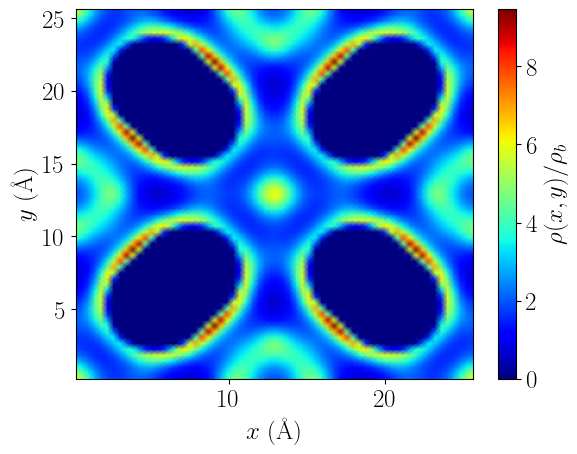

In [11]:
plt.figure()
c=plt.pcolormesh(dft.X[:,:,points[0]//2].cpu(),dft.Y[:,:,points[1]//2].cpu(),dft.rho[:,:,points[2]//2].cpu()/dft.rhob.cpu(),cmap='jet',shading='gouraud')
plt.colorbar(c, label=r'$\rho(x,y)/ \rho_b$')
plt.xlabel(r'$x$ (\AA{})')
plt.ylabel(r'$y$ (\AA{})')